In [1]:
import vitaldb
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
from combined_dataloader import * 
from ECG_beat_classifier import * 
import warnings
import pickle
import matplotlib.pyplot as plt
import os
import vitaldb
import random 
from scipy.signal import find_peaks
from utils2 import * 
import biosppy.signals.ecg 
import json 
import re
from pprint import pprint
from scipy.signal import find_peaks
from scipy.stats import linregress
from scipy.signal import find_peaks, savgol_filter
from typing import Dict, Union, List, Tuple


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BeatClassifier(input_length=360, num_classes=5).to(device)
modelname = 'Beat_classifier_best_model_1127'
model.load_state_dict(torch.load(modelname + '.pth'))

C:\Users\HP OMEN 45L GT22\AppData\Local\Temp\ipykernel_43696\1557213207.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelname + '.pt

<All keys matched successfully>

In [ ]:
def process_peaks(segment_data, start_idx, end_idx, start_second):
    """10초 구간의 ECG 데이터에서 peak 검출 및 처리"""
    # Initial peak detection using biosppy
    try:
        out = biosppy.signals.ecg.ecg(signal=segment_data, sampling_rate=360, show=False)
        peaks = out['rpeaks']
        peaks = [p + start_idx for p in peaks]  # Convert to absolute indices
    except Exception as e:
        print(f"Error in initial Biosppy detection: {str(e)}")
        peaks = []
    
    # HR 계산
    if len(peaks) >= 5:
        rr_intervals = np.diff(peaks) / 360
        hr = 60 / np.mean(rr_intervals)
        expected_rr = 60 / hr
    else:
        hr = 80
        expected_rr = 60 / hr
    
    # No detection regions 찾기
    no_detection_regions = []
    peaks.sort()
    original_peaks = peaks.copy()

    if len(peaks) < 5:
        no_detection_regions = [(start_second, start_second + 10)]
    else:
        for i in range(len(peaks)-1):
            gap = peaks[i+1]/360 - peaks[i]/360
            if gap > expected_rr * 1.2:
                no_detection_regions.append((peaks[i]/360, peaks[i+1]/360))
        
        if peaks[0]/360 - start_second > expected_rr * 1.2:
            no_detection_regions.append((start_second, peaks[0]/360))
        if start_second + 10 - peaks[-1]/360 > expected_rr * 1.2:
            no_detection_regions.append((peaks[-1]/360, start_second + 10))
    
    scipy_peaks = []
    
    # No detection regions에서 scipy peak 검출
    for start_time, end_time in no_detection_regions:
        detected_peaks = find_peaks_in_region(segment_data, start_time, end_time, start_second)
        scipy_peaks.extend(detected_peaks)
    print('kk',original_peaks)
    return original_peaks, scipy_peaks, hr, no_detection_regions


    
def classify_beats(ecg_data, peaks, model, device):
    """Beat classification 수행하고 예측 점수도 반환"""
    beat_signals = []
    valid_peaks = []
    peak_positions = set()

    for peak in peaks:
        if peak in peak_positions:
            continue
        peak = int(peak)
        beat_start = max(0, peak - int(0.4 * 360))
        beat_end = min(len(ecg_data), peak + int(0.6 * 360))
        
        if beat_end - beat_start == 360:
            beat_signal = ecg_data[beat_start:beat_end]
            beat_signal = (beat_signal - np.mean(beat_signal)) / (np.std(beat_signal) + 1e-8)
            beat_signals.append(beat_signal)
            valid_peaks.append(peak)
            peak_positions.add(peak)

    if not beat_signals:
        print("No valid beats found in the display window")
        return [], [], []

    # Batch로 처리
    beat_signals = torch.FloatTensor(beat_signals).to(device)
    
    with torch.no_grad():
        outputs = model(beat_signals)
        scores = torch.softmax(outputs, dim=1)  # softmax 적용하여 확률값으로 변환
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        scores = scores.cpu().numpy()  # scores를 numpy array로 변환
    
    return valid_peaks, predictions, scores

# Visualization 함수 수정

def visualize_ecg(display_ecg, valid_peaks, predictions, caseid, start_second, save_dir=None):
    """ECG 신호와 beat classification 결과 및 점수를 시각화"""
    global prediction_scores
    scores = prediction_scores  # global variable 사용
    
    plt.style.use('dark_background')
    plt.figure(figsize=(20, 6))
    
    # ECG 신호 그리기
    time_axis = np.arange(len(display_ecg))/360 + start_second
    plt.plot(time_axis, display_ecg, color='#00FF00', alpha=0.7, linewidth=1)
    
    # 클래스별 색상 매핑 설정
    class_names = {0: 'N', 1: 'P', 2: 'S', 3: 'U', 4: 'V'}
    class_colors = {
        'N': '#00FF00',  # 형광초록
        'S': '#FF0000',  # 빨강
        'U': '#FFA500',  # 주황
        'V': '#FF00FF'   # 마젠타
    }
    
    # Peak 위치에 따른 필터링 및 annotation
    i = 0
    while i < len(valid_peaks):
        peak = valid_peaks[i]
        pred_class = predictions[i]
        score = scores[i]
        class_label = class_names[pred_class]
        
        if class_label != 'P':
            peak_time = peak/360
            color = class_colors[class_label]
            pred_score = float(score[pred_class])
            
            # 인덱스 차이가 5 미만인 peak들은 건너뛰기
            j = i + 1
            skip_count = 0
            while j < len(valid_peaks) and (j - i) < 5:  # 인덱스 차이로 수정
                skip_count += 1
                j += 1
                
            # 클래스 레이블과 점수를 함께 표시
            annotation_text = f'{class_label}\n{pred_score:.2f}'
            plt.annotate(annotation_text, 
                        xy=(peak_time, display_ecg[int(peak - start_second * 360)]),
                        xytext=(0, 25),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        color='white',
                        fontweight='bold',
                        fontsize=14)
            plt.plot(peak_time, display_ecg[int(peak - start_second * 360)], 'o', 
                    color=color, markersize=8)
            
            i += skip_count + 1
        else:
            i += 1
    
    # x축과 y축 눈금 제거
    plt.xticks([])
    plt.yticks([])
    
    # 테두리 제거
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    # x축 범위 설정
    plt.xlim(start_second, start_second + 10)
    
    # 범례 생성 (P 클래스 제외)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=color, label=f'{label}',
                                markersize=10)
                      for label, color in class_colors.items()]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    # 그래프 저장 또는 표시
    if save_dir:
        filename = f'Case_{caseid}_{start_second}_.png'
        plt.savefig(os.path.join(save_dir, filename), 
                   facecolor='black', edgecolor='none',
                   bbox_inches='tight', dpi=300)
        print(f'Case {caseid} saved')
    else:
        plt.tight_layout()
        plt.show()
    
    plt.close()
def analyze_ecg_segment_v3(caseid, display_ecg, start_second, model, device):
    start_sample = 0 

    # Process peaks
    original_peaks, scipy_peaks, hr, no_detection_regions = process_peaks(
        display_ecg, start_sample, start_sample + 3600, start_second)
    
    # Combine all peaks
    all_detected_peaks = original_peaks + scipy_peaks
    
    # Filter close peaks (기존 코드와 동일)
    filtered_peaks = []
    i = 0
    while i < len(all_detected_peaks):
        current_peak = all_detected_peaks[i]
        max_amp_peak = current_peak
        max_amp = display_ecg[int(current_peak - start_sample)] if 0 <= int(current_peak - start_sample) < len(display_ecg) else -float('inf')
        j = i + 1
        
        while j < len(all_detected_peaks) and abs(all_detected_peaks[j] - current_peak) < 5:
            curr_amp = display_ecg[int(all_detected_peaks[j] - start_sample)] if 0 <= int(all_detected_peaks[j] - start_sample) < len(display_ecg) else -float('inf')
            if curr_amp > max_amp:
                max_amp_peak = all_detected_peaks[j]
                max_amp = curr_amp
            j += 1
        
        filtered_peaks.append(max_amp_peak)
        i = j if j > i + 1 else i + 1
    
    # Classify beats
    valid_peaks, predictions, scores = classify_beats(display_ecg, filtered_peaks, model, device)
    
    # 노이즈 구간 분석
    noise_regions, noise_percentage = analyze_segment_quality(valid_peaks, predictions, 0)
    
    # Clean 구간에서 HR 계산
    hr = calculate_hr_from_clean_regions(valid_peaks, predictions, noise_regions)
    
    # scores를 global variable로 저장하거나, visualization 함수 내에서 직접 계산
    global prediction_scores
    prediction_scores = scores
    
    return valid_peaks, predictions, hr, noise_regions, noise_percentage, display_ecg


    
    


In [17]:
caseid = 2058
vf = vitaldb.VitalFile(str(caseid) + '.vital')

signals = vf.to_numpy(['ECG_II'], 1/360)

ecg = signals[:,0]


dtstart = vf.dtstart  ## in sec 
dtend = vf.dtend ## in sec 



kk [199, 443, 594, 832, 983, 1218, 1368, 1600, 1746, 1985, 2132, 2371, 2519, 2760, 2911, 3149, 3299]
Noise Percentage: 0.0%
Heart Rate (from clean regions): 139.4 bpm
kk [199, 443, 594, 832, 983, 1218, 1368, 1600, 1746, 1985, 2132, 2371, 2519, 2760, 2911, 3149, 3299]


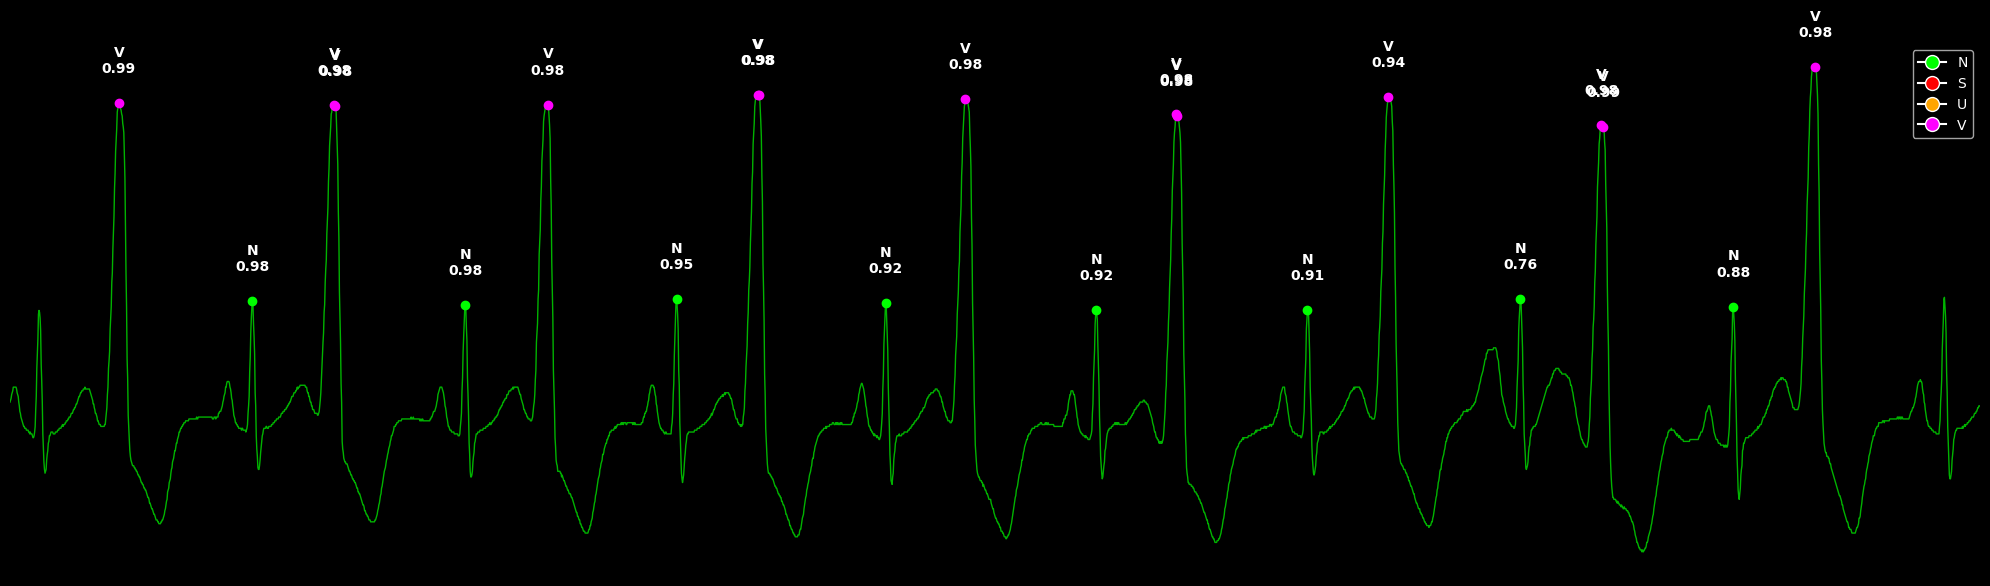

In [23]:

start_second = 688 
end_time = 688 + 1800
start_seconds = list(range(start_second, end_time + 1, 25))#[673-25,673,673+25]
start_second = start_seconds[0]

start_idx_ecg = int(start_second * 360)## 


segment_ecg = ecg[start_idx_ecg:start_idx_ecg + 3600]  # 10초 = 3600 샘플

valid_peaks, predictions, hr, noise_regions, noise_percentage, display_ecg = analyze_ecg_segment_v3(
    caseid, segment_ecg,start_second, model, device)

print(f"Noise Percentage: {noise_percentage:.1f}%")
if hr is not None:
    
    print(f"Heart Rate (from clean regions): {hr:.1f} bpm")
else:
    print("Unable to calculate reliable heart rate due to excessive noise")

# 시각화
valid_peaks, predictions, hr, noise_regions, noise_percentage, display_ecg= analyze_ecg_segment_v3(caseid, display_ecg, start_second, model, device)
visualize_ecg(display_ecg, valid_peaks, predictions, caseid, 0)